Notebook elaborado para apresentar uma breve introdução ao processamento de sinais.
Criado para a disciplina Geofísica I da Universidade Federal de Uberlândia.
O uso e a reprodução são livres para fins educacionais, pede-se apenas a citação da fonte.

[![License: GPL v3](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0)

Prof. Dr. Emerson Rodrigo Almeida<br>
Universidade Federal de Uberlândia<br>
Instituto de Geografia - Curso de Geologia<br>
emerson.almeida@ufu.br<br>

<p>&nbsp;</p>
Última modificação: 23/02/2021

# Instruções iniciais

Neste notebook você irá observar as variações relacionadas às anomalias ar-livre e Bouguer observadas em dados gravimétricos. Para isto leia atentamente as instruções apresentadas antes de cada célula e execute-as uma a uma, para acompanhar o processo corretamente.

Não se preocupe em compreender o código em si, não é obrigatório que você conheça a programação para obter e interpretar os resultados da demonstração. Mesmo assim, sinta-se livre caso queira perguntar qualquer coisa para aprender mais sobre o código e sua elaboração.

<p>&nbsp;</p>

### Passo 01 - Preparação

Primeiramente vamos preparar o notebook com os módulos e funções que precisaremos no decorrer da demonstração. A célula abaixo contém as funções utilizadas nos cálculos e as funções utilizadas para gerar as figuras. Execute-a uma vez antes de executar qualquer outra parte do código e **não altere nada no código apresentado na célula** para não criar problemas na execução do código.

Você pode executar o código na célula clicando sobre ela e em seguida clicando no botão **RUN** na barra do Jupyter Notebook ou pressionando as teclas **SHIFT+ENTER** no seu teclado.

<p>&nbsp;</p>

**Importante!** Nem todas as células irão retornar algum tipo de mensagem ou figura após a execução. Isto é normal e não significa que a execução tenha falhado. Perceba o símbolo **In [   ]:** próximo ao canto superior esquerdo de cada célula. Ao iniciar a execução de uma delas você verá um asterisco ($*$) aparecer dentro dos colchetes. Você saberá que a execução ocorreu sem problemas quando o $*$ dentro dos colchetes for substituído por um número e nenhuma mensagem de erro aparecer abaixo da célula executada. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def calc_gamma(l):
    """
    Calcula a aceleração da gravidade no elipsóide de referência (WGS 84) pela equação de Somigliana
    """
    
    a = 6378137.0
    b = 6356752.3142
    ga = 9.7803253359
    gb = 9.8321849378
    
    numerador = a * ga * np.cos(np.pi*l/180)**2 + b*gb*np.sin(np.pi*l/180)**2
    denominador = np.sqrt(a**2 * (np.cos(np.pi*l/180)**2) + b**2*(np.sin(np.pi*l/180)**2))
    
    return numerador/denominador


def plota_gamma(l, gamma):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(l, gamma)
    ax.set_xlabel('Latitude (º)', fontsize=14)
    ax.set_ylabel('g (m/s$^2$)', fontsize=14)
    ax.set_title('Aceleração da gravidade calculada pela fórmula de Somigliana', fontsize=14)
    ax.set_xlim([-90, 90])
    ax.set_ylim([9.75, 9.85])
    ax.grid()
    plt.show()
    
    
def seleciona_area(data, area):
    
    """
    Seleciona uma área no arquivo de dados a partir das coordenadas fornecidas. Foi feito asism
    para ser mais rápido do que plotar o arquivo todo e só depois selecionar a área.
    """

    if area[2] < 0:
        area[2] = 360 + area[2]
    if area[3] < 0:
        area[3] = 360 + area[3]

    d_lat = np.unique(data[:,1])[1] - np.unique(data[:,1])[0]
    d_lon = data[1, 0] - data[0, 0]
    
    # seleciona latitudes
    lat_ind1 = np.abs(data[:,1]-area[0]).argmin()
    lat_ind2 = np.abs(data[:,1]-area[1] + d_lat).argmin()
    data2 = data[lat_ind1:lat_ind2, :]

    # seleciona longitudes
    lon_inds = np.where((data2[:,0] > area[2]) & (data2[:,0] < (area[3] + d_lon)))
    data3 = data2[lon_inds[0], :]
   
    out_data = reorganiza(data3, area)

    return out_data


def reorganiza(d, area):
    
    d_lat = np.unique(d[:,1])[1] - np.unique(d[:,1])[0]
    d_lon = d[1, 0] - d[0, 0]
    
    if np.shape(d)[1]==4:
        lon, lat, alt, g = d[:,0], d[:,1], d[:,2], d[:,3]
        lon2 = lon[:int(np.abs(area[3]-area[2])/d_lon)]
        lat2 = np.reshape(lat, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])[:, 1]  # acho que não precisa desse indice
        alt2 = np.reshape(alt, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])
        g2 = np.reshape(g, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])

        return [lon2, lat2, alt2, g2]
    
    if np.shape(d)[1]==3:
        lon, lat, topog = d[:,0], d[:,1], d[:,2]
        lon2 = lon[:int(np.abs(area[3]-area[2])/d_lon)]
        lat2 = np.reshape(lat, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])[:, 1]  # acho que não precisa desse indice
        topog2 = np.reshape(topog, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])

        return [lon2, lat2, topog2]


def plota_mapa(xx, yy, zz, title=None, escala=None):

    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    z = plt.contourf(xx, yy, zz, 120, transform=ccrs.PlateCarree(), cmap='RdBu_r')
    
    if escala:
        plt.colorbar(z, ax=ax, label=escala, shrink=0.5)

    ax.coastlines(resolution='50m')
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    
    if title:
        ax.set_title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

# Passo 01 - Dados de elevação

Primeiramente, carrege o arquivo ASCII que contém os dados de topografia do mundo todo, discretizados em um grid de 0.5 grau, e medidas da aceleração da gravidade tomadas nestes pontos. Este arquivo é disponibilizado pelo [International Centre for Global Earth Models - ICGEM](http://icgem.gfz-potsdam.de/home), podendo ser feito o download direto [neste link](http://icgem.gfz-potsdam.de/getmodel/doc/7de5f4776818768629ccc05741eab71caea0753f591b5fa16769d49a58c8d9ea) - mas você não precisa baixá-lo para fazer a atividade.

Carregue este arquivo executando a célula abaixo.

In [2]:
dados = np.loadtxt('eigen-6c3stat-0_5-mundo.txt')

Carregue também um segundo arquivo com os dados de topografia e de batimetria dos oceanos, dado pelo modelo digital de terreno ETOPO1 pelo [
National Oceanic and Atmospheric Administration - NOAA](http://www.ngdc.noaa.gov/mgg/global/global.html), executando a célula abaixo.

In [3]:
topog = np.loadtxt('etopo1-0_5-mundo.txt')

### Passo 02 - Aceleração da gravidade no elipsóide



Agora, antes de trabalhar com os dados  calcule a aceleração da gravidade sobre o elipsóide de referência definido pelo WGS84. Este cálculo é feito pela fórmula de Somigliana, dada por:

$$\gamma(\phi) = \frac{a*\gamma_a*cos^2\phi + b*\gamma_b*sen^2\phi}{\sqrt{a^2*cos^2\phi + b^2*sen^2\phi}}$$

em que $\gamma$ é a componente vertical da gravidade no Equador, $\gamma_b$ é a componente vertical da gravidade nos Polos, $a$ é o raio equatorial da Terra e $b$ é o raio polar da Terra. Estes valores são dados por:

$a$ = 6378137 m; $b$ = 6356752.3142 m; $\gamma_a$ = 9.7803253359 m/s$^2$; $\gamma_b$ = 9.8321849378 m/s$^2$

In [4]:
lat = np.unique(dados[:,1])
somig = calc_gamma(lat)

e execute a célula abaixo para obter o gráfico que representa o cálculo acima.

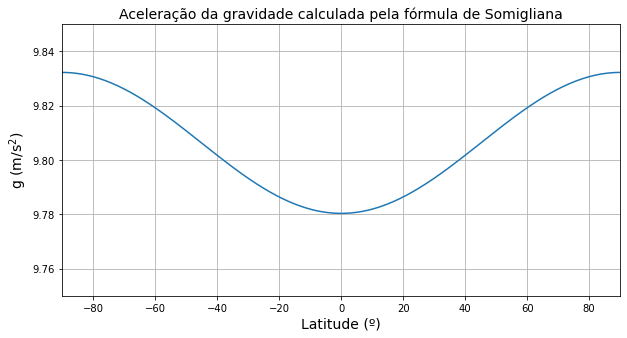

In [5]:
plota_gamma(lat, somig)

**Explique o gráfico acima.** Quais fatores contribuem para este comportamento?

### Passo 03 - Mapa de Topografia

Você vai selecionar uma região do mapa, correspondente à America do Sul. Execute a célula abaixo para definir as coordenadas referentes a esta região.

In [6]:
regiao = [15.0, -60.0, -90.0, -30.0]      # [lat_min, lat_max, lon_min, lon_max]    América do Sul
#regiao = [-10.0, -30.0, -80.0, -60.0]    # [lat_min, lat_max, lon_min, lon_max]    América do Sul (zoom nos Andes)
#regiao = [60.0, 00.0, 50.0, 120.0]       # [lat_min, lat_max, lon_min, lon_max]    Himalaia
#regiao = [60.0, -60.0, -60.0, -5.0]       # [lat_min, lat_max, lon_min, lon_max]    dorsal
#regiao = [70, 10, 120, 170]

e execute a célula abaixo para visualizar o mapa

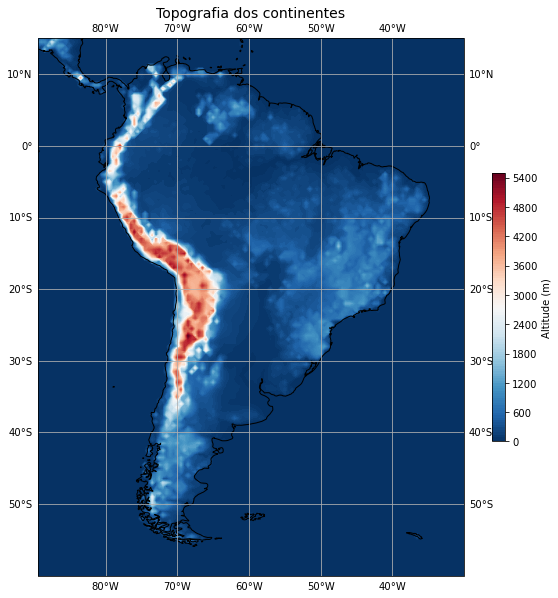

In [7]:
lon, lat, h, g_medido = seleciona_area(dados, regiao)
plota_mapa(lon, lat, h, title='Topografia dos continentes', escala='Altitude (m)')

### Passo 04 - Anomalia Ar-livre

Agora serão corrigidas as influências da latitude e da altitude dos pontos de aquisição de dados. A primeira é denominada **correção de latitude** ($C_LAT$) e utiliza a aceleração da gravidade sobre o elipsóide ($\gamma$), calculada no Passo 02. Este valor será subtraído do valor medido da aceleração da gravidade. Adicionalmente, aplica-se a **correção ar-livre**, para compensar a variação causada pelo gradiente vertical relacionado à altitude ortométrica ($H$) do ponto de aquisição do dado. A correção ar-livre ($C_{AL}$) é calculada por

$$C_{AL} = 0.3086 * H$$

Ao resultado deste cálculo dá-se o nome de **anomalia ar-livre ($g_{AL}$)** a qual inclui a correção de latitude e é definida por:

$$g_{AL} = g_{medido} + C_{LAT} + C_{AL} = g_{medido} - \gamma + 0.3086 * H$$

Execute a célula abaixo para aplicar esta correção e visualizar o mapa de anomalia ar-livre:

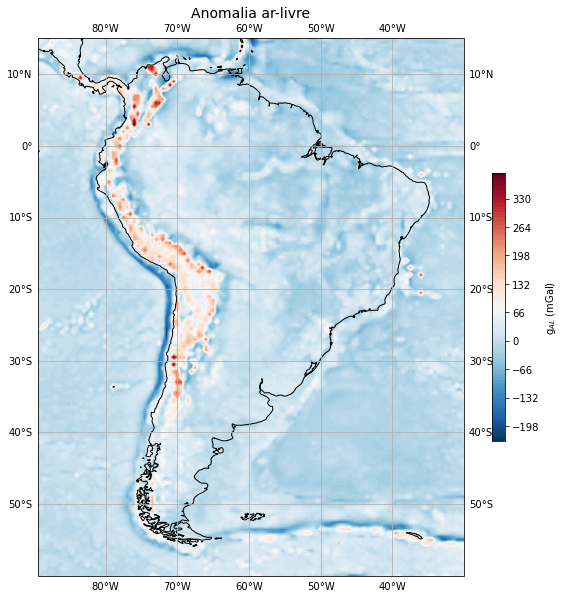

In [8]:
gamma = np.repeat(calc_gamma(lat)*1e5, np.shape(g_medido)[1])
gamma = np.reshape(gamma, np.shape(g_medido))
g_al = g_medido - gamma + 0.3086 * h
plota_mapa(lon, lat, g_al, title='Anomalia ar-livre', escala='g$_{AL}$ (mGal)')

**Em uma folha de papel** faça uma estimativa do perfil passando pelo paralelo -20º e entre os meridianos -80º e -60º considerando os valores de anomalia ar-livre observados. Explique este comportamento.

### Passo 05 - Anomalia Bouger

Por fim, será feita a remoção da influência das massas rochosas que, lembre-se, não foi compensada no passo anterior. Para isto, será feita a **correção Bouguer** ($C_B$), que é feita considerando-se a variação de densidade causada pelas rochas acima da superfície de referência ($\Delta_{\rho}$).

Execute a célula abaixo para visualizar um mapa de elevação do topo rochoso considerando também a batimetria dos oceanos, pois ela será importante nesta etapa:

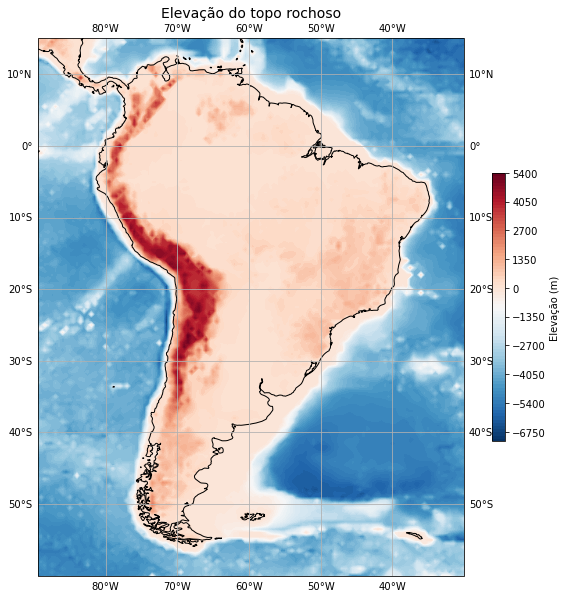

In [9]:
lon, lat, elev = seleciona_area(topog, regiao)
plota_mapa(lon, lat, elev, title='Elevação do topo rochoso', escala='Elevação (m)')

Nesta demonstração será feita a correção Bouguer simples, onde a cada ponto de altitude atribui-se uma placa de densidade homogênea e horizontal, não sendo considerados os efeitos da esfericidade da Terra. Desta forma, a variação de densidade sobre os continentes corresponde à densidade das rochas acima do elipsóide. Porém, observe que nos oceanos não há massa rochosa para ser removida, porém há uma massa de água abaixo da superfície do elipsóide e que exerce um efeito gravitacional diferente da massa rochosa que existe abaixo deste *datum* nos continentes e é igualmente necessário compensá-la nos dados. Assim, em regiões oceânicas a variação de densidade para a correção Bouguer é dada por $\Delta_{\rho} = \rho_r - \rho_w$, em que $\rho_w$ é a densidade da água. Nesta correção serão utilizados os valores de $\rho_r$ = 2670 kg m$^3$ e $\rho_w$ = 1040 kg m$^3$. A correção Bouguer é aplicada logo após o cálculo da anomalia ar-livre. Juntando-se todas as compensações feitas anteriormente, tem-se a anomalia Bouguer ($g_B$), dada por:

$$g_{AL} = g_{medido} + C_{LAT} + C_{AL} + C_B = g_{medido} - \gamma + 0.3086 * H - 2 * \pi * G * \Delta_{\rho} * H$$

em que $G$ = 6.67408 * 10$^{-11}$ m$^3$ kg$^{-1}$ s$^{-2}$ é a constante gravitacional.

Execute a célula abaixo para executar esta correção.

In [10]:
G = 6.67408e-11      # m^3 kg^-1 s^-2
rho_r = 2670         # kg m^3
rho_w = 1040         # kg m^3

b_pos = np.zeros(np.shape(elev))
b_neg = np.zeros(np.shape(elev))

b_pos[elev>=0] = 2 * np.pi * G * rho_r * elev[elev>=0]
b_neg[elev<0] = 2 * np.pi * G * (rho_r - rho_w) * elev[elev<0]
corr_b = (b_pos + b_neg)     # m/s^2

g_b = g_al - (corr_b*1e5)    # mGal

e execute a célula abaixo para visualizar o mapa de anomalia Bouguer resultante deste procedimento:

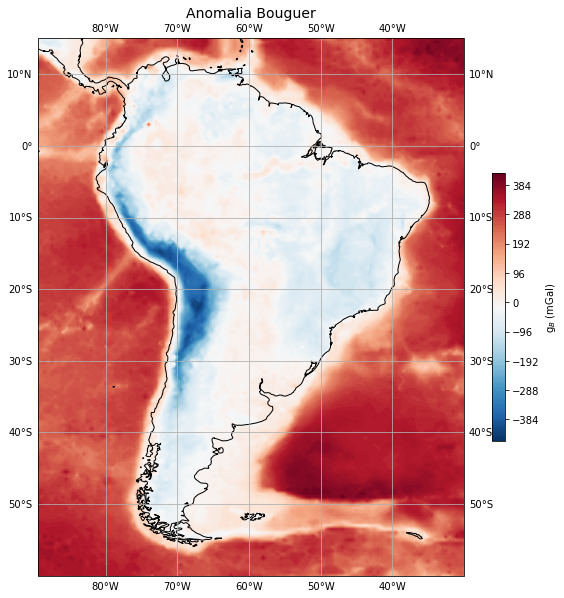

In [11]:
plota_mapa(lon, lat, g_b, title='Anomalia Bouguer', escala='g$_B$ (mGal)')